In [51]:
import os
import sys

import numpy as np
import librosa
import librosa.display

import pysptk
import pysas
from scipy.io import wavfile

import matplotlib.pyplot as plt
import seaborn
seaborn.set(style="dark")

import pyaudio
import wave

from pysptk.synthesis import Synthesizer, MLSADF, LMADF, MGLSADF, MGLSADF

%matplotlib inline

In [52]:
from IPython.display import Audio

In [136]:
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 16000
CHUNK = 1024
PERIOD = 80
ALPHA = 0.42
ORDER = 25

SAMPLE_AUDIO_00 = 'sample_00.wav'
SAMPLE_AUDIO_01 = 'sample_01.wav'

### Record Function

In [54]:
def record(output_raw_file, record_seconds):
    
    audio = pyaudio.PyAudio()

    # start Recording
    stream = audio.open(format=FORMAT, channels=CHANNELS,
                        rate=RATE, input=True,
                        frames_per_buffer=CHUNK)

    print("recording...")
    frames = []

    for i in range(0, int(RATE / CHUNK * record_seconds)):
        data = stream.read(CHUNK)
        frames.append(data)

    print("finished recording")


    # stop Recording
    stream.stop_stream()
    stream.close()
    audio.terminate()


    file = open(output_raw_file, "wb")
    file.write(b''.join(frames))
    file.close()

### rawPlay Function

In [55]:
def raw2wav(fn):
    os.system("raw2wav %s" % fn)

In [56]:
def plot_audio(x, fs):
    librosa.display.waveplot(x, fs)

In [57]:
def wavfile_orig(fn):
    fs, x = wavfile.read("%s" % fn)
    return fs, x

In [58]:
def play_wav(x, fs):
    return Audio(x, rate=fs)

### extract Pitch Function

In [59]:
def plot_pitch(x, fs):
     return plt.plot(x, linewidth=3, label="F0 trajectory estimated by SWIPE'")

In [60]:
def extract_pitch(x, fs):
    plot_pitch(x, fs)
    return pysptk.swipe(x.astype(np.float64), fs=fs, hopsize=80, min=60, max=200, otype="f0")

In [61]:
# hop_length = frame period

def get_frame(x, frame_length=1024, hop_length=80):
    return librosa.util.frame(x, frame_length, hop_length).astype(np.float64).T

In [62]:
def plot_mfcc(mcep, fs, alpha, frame_length, hop_length): 
    logH = pysptk.mgc2sp(mcep, alpha, 0.0, frame_length).real
    librosa.display.specshow(logH.T, sr=fs, hop_length=hop_length, x_axis="time", y_axis="linear")
    plt.colorbar()
    plt.title("Spectral envelope estimate from mel-cepstrum")

In [63]:
def extract_mfcc(x, fs, frame_length=1024, hop_length=80, order=25, alpha=0.42):
    frame = get_frame(x, frame_length, hop_length)
    windowed = frame * pysptk.blackman(frame_length)
    mcep = pysptk.mcep(windowed, order, alpha)
    plot_mfcc(mcep, fs, alpha, frame_length, hop_length)
    return mcep

### synthesize audio picth or speed

In [105]:
def  set_voice(x, fs, pitch, mfcc, hop_length=80, order=25, alpha=0.42, pitch_rate=1.0, mfcc_rate=1.0):
    b =pysptk.mc2b(mfcc * pitch_rate, alpha);
    synthesizer = Synthesizer(MLSADF(order=order, alpha=alpha), hop_length)
    
    source_excitation = pysptk.excite(pitch * mfcc_rate, hop_length)
    
    # source_excitation = pitch

    x_synthesized = synthesizer.synthesis(source_excitation, b)
    
    plot_audio(x_synthesized, fs)
    return play_wav(x_synthesized, fs)

### Main Function

#### 01. 音声録音と特徴量の抽出

* 5秒間の音声録音
* 録音したrawデータをwavに変換
* wavファイルから、fs, xの取得
* fs, xから特徴量の抽出

In [79]:
record('./raw/test.raw', 5.0)

recording...
finished recording


In [80]:
raw2wav('./raw/test.raw')

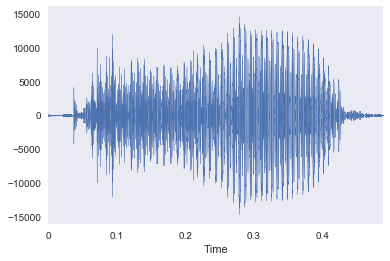

In [137]:
fs, x = wavfile_orig(SAMPLE_AUDIO_00)
plot_audio(x, fs)

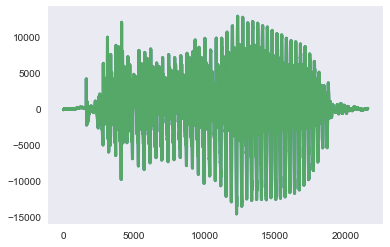

In [138]:
pitch = extract_pitch(x, fs)
plot_pitch(x, fs)

In [139]:
play_wav(x, fs)

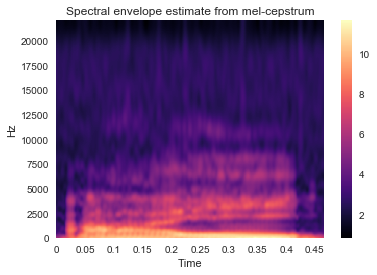

In [140]:
mfcc = extract_mfcc(x, fs, frame_length=CHUNK, hop_length=PERIOD)

#### 02. ピッチの調整

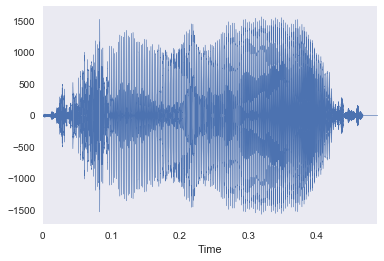

In [159]:
set_voice(x, fs, pitch, mfcc, hop_length=PERIOD, order=ORDER, alpha=ALPHA, pitch_rate=1.0,  mfcc_rate=1.0)